In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import random_split, DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from pyts.image import GramianAngularField
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

# Without GAF

In [81]:
class StockCandlestickDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith(".png")
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = 1 if "Bullish" in img_path else 0

        return image, label

# With GAF

In [114]:
class StockCandlestickDatasetWithGAF(Dataset):
    def __init__(self, data_dir, transform=None, gaf_image_size=224):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith(".png")
        ]
        self.gaf_transformer = GramianAngularField(image_size=gaf_image_size, method='summation')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        image = Image.open(img_path).convert('L')
        image_array = np.array(image)
        
        gaf_image = self.gaf_transformer.fit_transform(image_array.reshape(1, -1))[0]
       
        gaf_image = Image.fromarray((gaf_image * 255).astype(np.uint8)).convert("RGB")
        
        if self.transform:
            gaf_image = self.transform(gaf_image)
        
        label = 1 if "Bullish" in img_path else 0

        return gaf_image, label

# Regular Dataset

In [82]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = 'D:\\codyb\\COMP6970_Final_Project_Data\\charts\\20_minute_intervals'

dataset = StockCandlestickDataset(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# GAF Dataset

In [115]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = 'D:\\codyb\\COMP6970_Final_Project_Data\\charts\\20_minute_intervals'

dataset = StockCandlestickDatasetWithGAF(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [116]:
class CandlestickClassifier(nn.Module):
    def __init__(self):
        super(CandlestickClassifier, self).__init__()
        
        self.vgg_base = models.vgg16().features
        for param in self.vgg_base.parameters():
            param.requires_grad = False
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(512, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.vgg_base(x)
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

In [117]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)

PyTorch version: 2.5.1+cu118
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
GPU 0: NVIDIA GeForce GTX 1660 Ti
Device being used: cuda


The results are very dependent on the run. I think there might not be enough data to guarantee convergence. Will test on a larger dataset later.

Epoch [1/20], Loss: 0.6938
Epoch [2/20], Loss: 0.6924
Epoch [3/20], Loss: 0.6912
Epoch [4/20], Loss: 0.6897
Epoch [5/20], Loss: 0.6886
Epoch [6/20], Loss: 0.6865
Epoch [7/20], Loss: 0.6854
Epoch [8/20], Loss: 0.6860
Epoch [9/20], Loss: 0.6847
Epoch [10/20], Loss: 0.6846
Epoch [11/20], Loss: 0.6841
Epoch [12/20], Loss: 0.6829
Epoch [13/20], Loss: 0.6813
Epoch [14/20], Loss: 0.6796
Epoch [15/20], Loss: 0.6755
Epoch [16/20], Loss: 0.6696
Epoch [17/20], Loss: 0.6506
Epoch [18/20], Loss: 0.6236
Epoch [19/20], Loss: 0.5863
Epoch [20/20], Loss: 0.5678


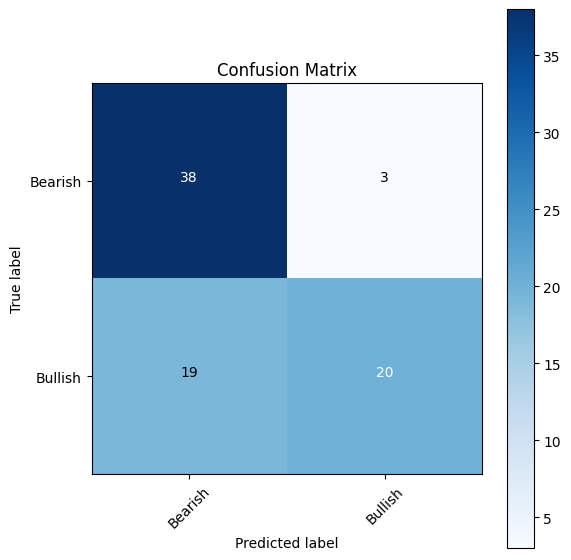

Test Accuracy: 72.50%


In [118]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CandlestickClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels).flatten()
all_predictions = np.array(all_predictions).flatten()

conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["Bearish", "Bullish"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.0
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

accuracy = np.sum(all_predictions == all_labels) / len(all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Accuracies
This was performed on my curated training set. **HAS NOT been performed on my real set yet.**

**All with Adam Optimizer**

**When 48.75% Accuracy, Will label all Bullish**
- Graph Trend: (Bullish, Bearish) 
    - With GAF:
        - 5 epochs, 1e-2 LR: 48.75%
        - 5 epochs, 1e-3 LR: 48.75%
        - 5 epochs, 1e-4 LR: 48.75%
        - 10 epochs, 5e-3 LR: 48.75%
        - 10 epochs, 1e-3 LR: 48.75%
        - 10 epochs, 1e-4 LR: 48.75%
        - 20 epochs, 1e-3 LR: 48.75%
        - 20 epochs, 5e-4 LR: 75%
        - 20 epochs, 1e-4 LR: 73.75%
        - 25 epochs, 5e-4 LR: 75%
        - 25 epochs, 1e-4 LR: 73.75%
    - Without GAF:
        - 5 epochs, 1e-2 LR: 95%
        - 5 epochs, 5e-3 LR: 57.5%
        - 5 epochs, 1e-3 LR: 48.75%
        - 5 epochs, 5e-4 LR: 48.75%
        - 5 epochs, 1e-4 LR: 48.75%
        - 10 epochs, 5e-3 LR: 96.25%
        - 10 epochs, 1e-3 LR: 96.25%
        - 10 epochs, 5e-4 LR: 52.5%
        - 10 epochs, 1e-4 LR: 48.75%
        - 20 epochs, 5e-3 LR: 96.25%
        - 20 epochs, 1e-3 LR: 96.25%
        - 20 epochs, 5e-4 LR: 97.5%
        - 20 epochs, 1e-4 LR: 95%
- Candlestick Patterns (With None): (Bullish Engulfing, Morning Star, Shooting Star, Hanging Man, Bullish Harami, None, Inverted Hammer, Hammer, Evening Star,Bearish Engulfing)
    - With GAF:
        - X
    - Without GAF:
        - 10 epochs, 1e-3 LR: 80.24%
        - 20 epochs, 1e-3 LR:
- Candlestick Patterns (Without None): (Bullish Engulfing, Morning Star, Shooting Star, Hanging Man, Bullish Harami, Inverted Hammer, Hammer, Evening Star,Bearish Engulfing)
    - With GAF:
    - Without GAF:
        - 20 epochs, 

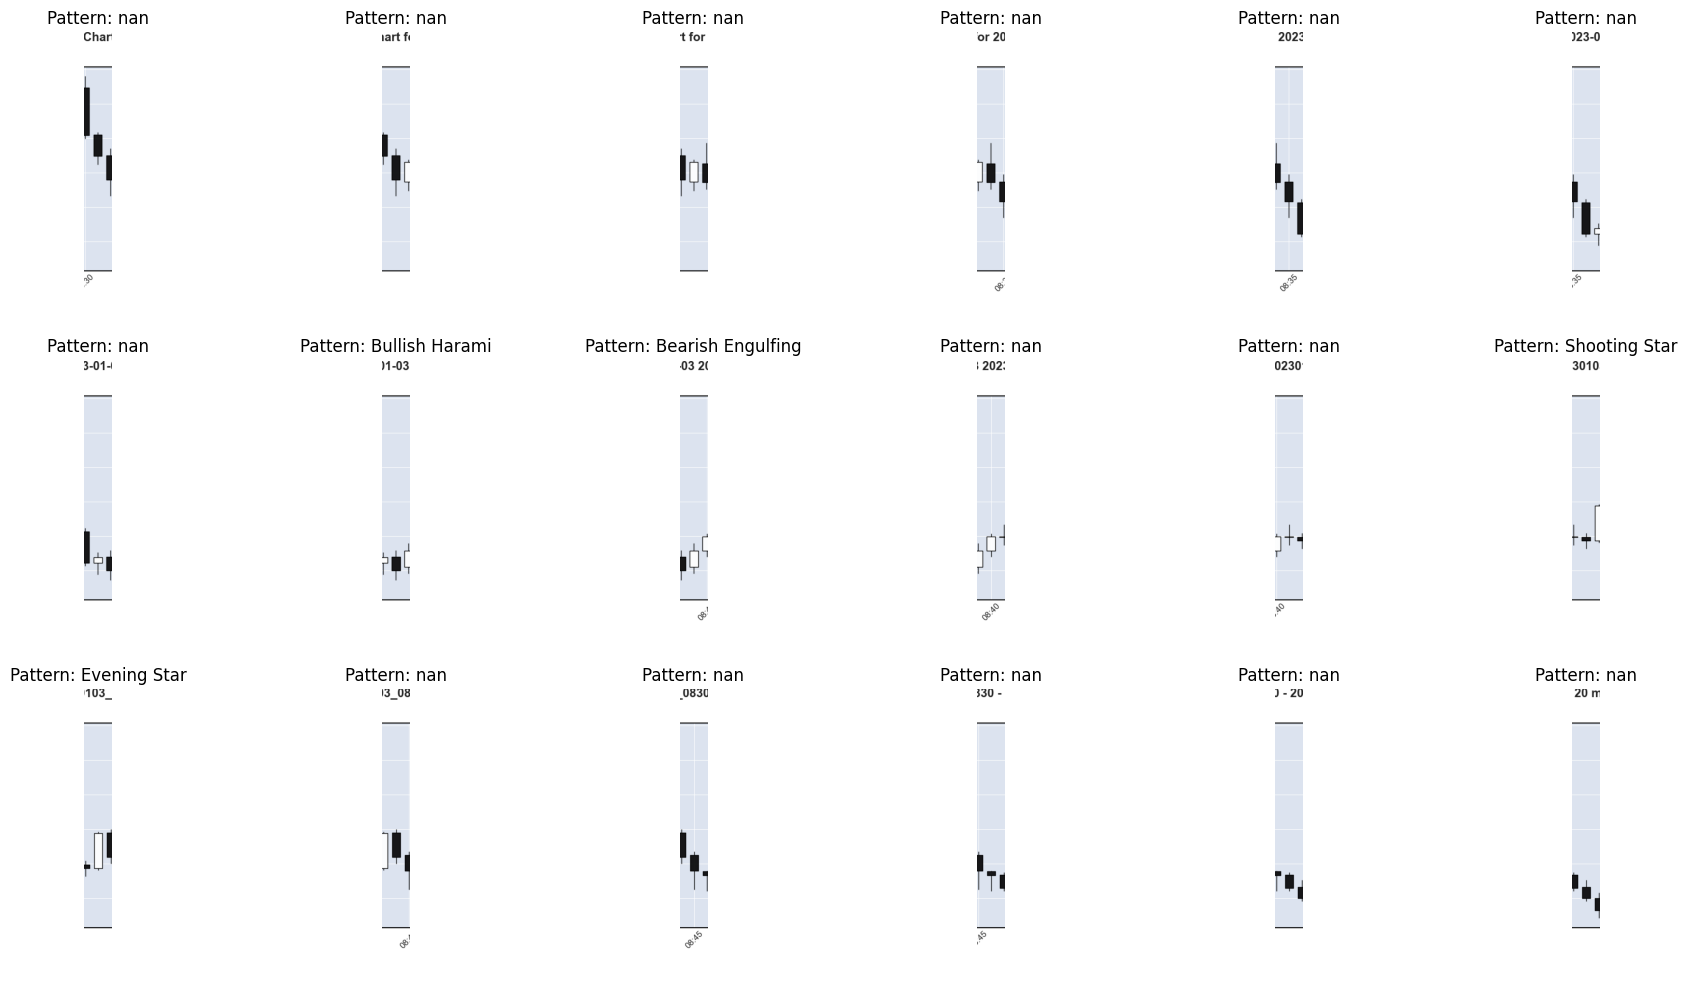

In [ ]:
image_path = "D:\\codyb\\COMP6970_Final_Project_Data\\charts\\20_minute_intervals\\TSLA_Candlestick_20230103_0830_to_0850_Bearish.png"
image = cv2.imread(image_path)
image_height, image_width, _ = image.shape

csv_data = pd.read_csv("./labeling/TSLA_minute_data_cleaned_labeled.csv")

x_start = 192
x_end = 677
total_width = x_end - x_start

window_width = 55
overlap_increment = 25

candlestick_images = []
candlestick_labels = []

for i in range(18):
    section_start = x_start + i * overlap_increment
    section_end = section_start + window_width

    if section_end > x_end:
        break
    
    candlestick_crop = image[:, section_start:section_end]
    candlestick_images.append(candlestick_crop)
    
    label_index = min(i, len(csv_data) - 1)
    candlestick_labels.append(csv_data["Candlestick Pattern"].iloc[label_index])

num_images = len(candlestick_images)
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for idx, ax in enumerate(axes.flat):
    if idx < num_images:
        crop_rgb = cv2.cvtColor(candlestick_images[idx], cv2.COLOR_BGR2RGB)
        ax.imshow(crop_rgb)
        ax.set_title(f"Pattern: {candlestick_labels[idx]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

# Label Dataset
Full dataset with None labels.

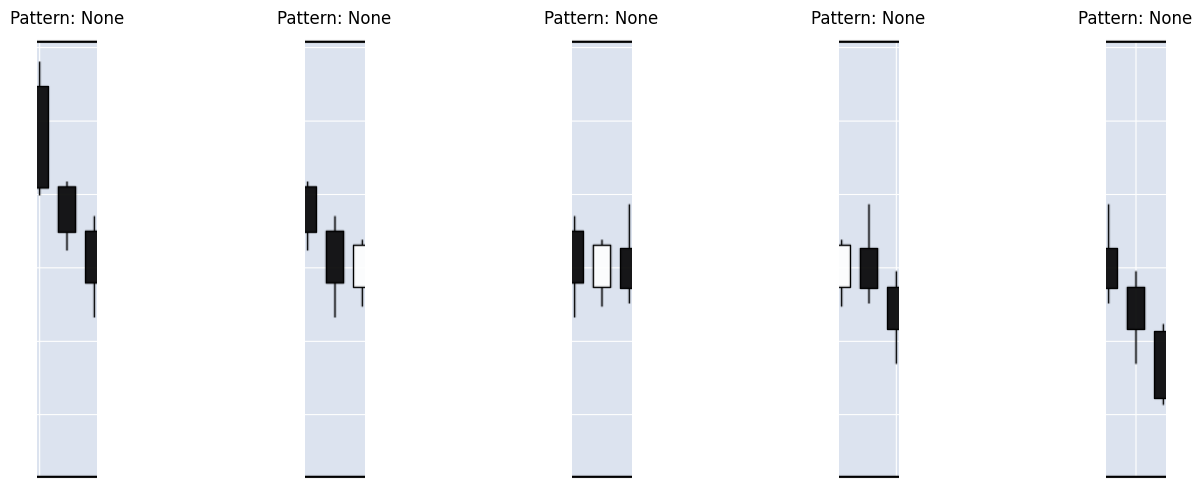

Unique labels: {'Bullish Engulfing', 'Morning Star', 'Shooting Star', 'Hanging Man', 'Bullish Harami', 'None', 'Inverted Hammer', 'Hammer', 'Evening Star', 'Bearish Engulfing'}
Number of unique labels: 10


In [119]:
image_dir = "D:\\codyb\\COMP6970_Final_Project_Data\\charts\\20_minute_intervals\\"
csv_path = "./labeling/TSLA_minute_data_cleaned_labeled.csv"

csv_data = pd.read_csv(csv_path)
csv_data['datetime'] = pd.to_datetime(csv_data['datetime'])

x_start = 192
x_end = 677
total_width = x_end - x_start
window_width = 55
overlap_increment = 25

all_candlestick_images = []
all_candlestick_labels = []

for filename in os.listdir(image_dir):
    if filename.endswith(".png"):
        parts = filename.split('_')
        date_str = parts[2]
        time_str = parts[3][:4]
        datetime_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]} {time_str[:2]}:{time_str[2:]}"
        start_datetime = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M")

        start_index = csv_data[csv_data['datetime'] == start_datetime].index
        if len(start_index) == 0:
            print(f"No matching datetime found in CSV for file {filename}")
            continue
        start_index = start_index[0]

        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)

        candlestick_images = []
        candlestick_labels = []
        for i in range(18):
            section_start = x_start + i * overlap_increment
            section_end = section_start + window_width

            if section_end > x_end:
                break

            candlestick_crop = image[60:475, section_start:section_end]
            candlestick_images.append(candlestick_crop)

            label_index = start_index + i + 1
            if label_index < len(csv_data):
                label = csv_data["Candlestick Pattern"].iloc[label_index]
                if pd.isna(label):
                    label = "None"
                candlestick_labels.append(label)

        all_candlestick_images.extend(candlestick_images)
        all_candlestick_labels.extend(candlestick_labels)

num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for idx in range(num_images_to_display):
    image_rgb = cv2.cvtColor(all_candlestick_images[idx], cv2.COLOR_BGR2RGB)
    axes[idx].imshow(image_rgb)
    axes[idx].set_title(f"Pattern: {all_candlestick_labels[idx]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

unique_labels = set(all_candlestick_labels)
print("Unique labels:", unique_labels)
print("Number of unique labels:", len(unique_labels))

# Label Dataset
Dataset without None labels.

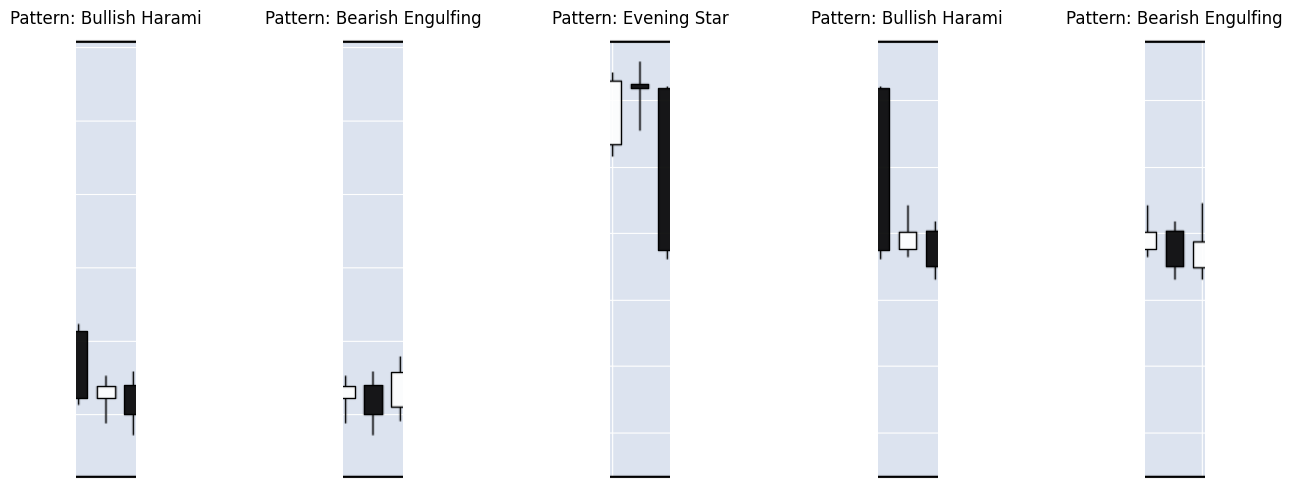

Unique labels: {'Bullish Engulfing', 'Morning Star', 'Shooting Star', 'Hanging Man', 'Bullish Harami', 'Inverted Hammer', 'Hammer', 'Evening Star', 'Bearish Engulfing'}
Number of unique labels: 9


In [145]:
image_dir = "D:\\codyb\\COMP6970_Final_Project_Data\\charts\\20_minute_intervals\\"
csv_path = "./labeling/TSLA_minute_data_cleaned_labeled.csv"

csv_data = pd.read_csv(csv_path)
csv_data['datetime'] = pd.to_datetime(csv_data['datetime'])

x_start = 192
x_end = 677
total_width = x_end - x_start
window_width = 55
overlap_increment = 25

all_candlestick_images = []
all_candlestick_labels = []

for filename in os.listdir(image_dir):
    if filename.endswith(".png"):
        parts = filename.split('_')
        date_str = parts[2]
        time_str = parts[3][:4]
        datetime_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]} {time_str[:2]}:{time_str[2:]}"
        start_datetime = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M")

        start_index = csv_data[csv_data['datetime'] == start_datetime].index
        if len(start_index) == 0:
            print(f"No matching datetime found in CSV for file {filename}")
            continue
        start_index = start_index[0]

        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)

        candlestick_images = []
        candlestick_labels = []
        for i in range(18):
            section_start = x_start + i * overlap_increment
            section_end = section_start + window_width

            if section_end > x_end:
                break

            candlestick_crop = image[60:475, section_start:section_end]
            candlestick_images.append(candlestick_crop)

            label_index = start_index + i + 1
            if label_index < len(csv_data):
                label = csv_data["Candlestick Pattern"].iloc[label_index]
                if pd.isna(label):
                    label = "None"
                candlestick_labels.append(label)

        all_candlestick_images.extend(candlestick_images)
        all_candlestick_labels.extend(candlestick_labels)

# Filter out "None" labels
filtered_images_labels = [
    (img, lbl) for img, lbl in zip(all_candlestick_images, all_candlestick_labels) if lbl != "None"
]
all_candlestick_images, all_candlestick_labels = zip(*filtered_images_labels)

num_images_to_display = 5
fig, axes = plt.subplots(1, min(num_images_to_display, len(all_candlestick_images)), figsize=(15, 5))

for idx in range(min(num_images_to_display, len(all_candlestick_images))):
    image_rgb = cv2.cvtColor(all_candlestick_images[idx], cv2.COLOR_BGR2RGB)
    axes[idx].imshow(image_rgb)
    axes[idx].set_title(f"Pattern: {all_candlestick_labels[idx]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

unique_labels = set(all_candlestick_labels)
print("Unique labels:", unique_labels)
print("Number of unique labels:", len(unique_labels))

# Regular Implementation

In [131]:
class CandlestickDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL image if using transforms
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        
        return image, label

# GAF Implementation

In [153]:
class CandlestickDatasetWithGAF(Dataset):
    def __init__(self, images, labels, transform=None, image_size=(224, 224)):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.image_size = image_size
        self.gaf = GramianAngularField(image_size=self.image_size[0])  # Define GAF with desired output size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Resize image for GAF if needed
        image_resized = cv2.resize(image, (self.image_size[0], self.image_size[1]))
        
        # Normalize image data to range [0, 1] before GAF transformation
        image_resized = image_resized / 255.0

        # Convert the grayscale image data to GAF format
        image_gaf = self.gaf.fit_transform(image_resized.reshape(1, -1)).squeeze()
        
        # Ensure the GAF image has the correct dimensions for CNN input
        if image_gaf.ndim == 2:  # Single channel
            image_gaf = np.repeat(image_gaf[np.newaxis, :, :], 3, axis=0)  # Convert to 3 channels (C, H, W)

        # Convert to Tensor
        if self.transform:
            image_gaf = self.transform(image_gaf.transpose(1, 2, 0))  # Transpose to HWC for torchvision

        return image_gaf, label

In [154]:
class CandlestickCNN(nn.Module):
    def __init__(self, num_classes):
        super(CandlestickCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [155]:
label_encoder = LabelEncoder()
all_candlestick_labels_encoded = label_encoder.fit_transform(all_candlestick_labels)

label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

num_classes = len(label_encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    all_candlestick_images, all_candlestick_labels_encoded, test_size=0.2, random_state=42
)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
])

Label Mapping:
Bearish Engulfing: 0
Bullish Engulfing: 1
Bullish Harami: 2
Evening Star: 3
Hammer: 4
Hanging Man: 5
Inverted Hammer: 6
Morning Star: 7
Shooting Star: 8


# Regular Dataset

In [143]:
train_dataset = CandlestickDataset(X_train, y_train, transform=transform)
test_dataset = CandlestickDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# GAF Dataset

In [157]:
train_dataset = CandlestickDatasetWithGAF(X_train, y_train, transform=transform)
test_dataset = CandlestickDatasetWithGAF(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CandlestickCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)

class_names = [label_mapping[i] for i in range(num_classes)]

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Training Epoch 1/20:   0%|          | 0/36 [00:00<?, ?it/s]

Training Epoch 1/20: 100%|██████████| 36/36 [00:05<00:00,  6.90it/s]


Epoch [1/20], Loss: 1.7662


Training Epoch 2/20: 100%|██████████| 36/36 [00:05<00:00,  7.03it/s]


Epoch [2/20], Loss: 1.6593


Training Epoch 3/20: 100%|██████████| 36/36 [00:05<00:00,  6.66it/s]


Epoch [3/20], Loss: 1.5552


Training Epoch 4/20: 100%|██████████| 36/36 [00:05<00:00,  7.07it/s]


Epoch [4/20], Loss: 1.4793


Training Epoch 5/20: 100%|██████████| 36/36 [00:05<00:00,  7.14it/s]


Epoch [5/20], Loss: 1.3838


Training Epoch 6/20: 100%|██████████| 36/36 [00:05<00:00,  6.70it/s]


Epoch [6/20], Loss: 1.2772


Training Epoch 7/20: 100%|██████████| 36/36 [00:06<00:00,  5.85it/s]


Epoch [7/20], Loss: 1.1890


Training Epoch 8/20: 100%|██████████| 36/36 [00:06<00:00,  5.61it/s]


Epoch [8/20], Loss: 1.1395


Training Epoch 9/20: 100%|██████████| 36/36 [00:06<00:00,  5.52it/s]


Epoch [9/20], Loss: 1.0339


Training Epoch 10/20:  72%|███████▏  | 26/36 [00:04<00:02,  4.89it/s]

# Accuracies
This was performed on my curated training set. **HAS NOT been performed on my real set yet.**

**All with Adam Optimizer**

**When 48.75% Accuracy, Will label all Bullish**
- Graph Trend: (Bullish, Bearish) 
    - With GAF:
        - 5 epochs, 1e-2 LR: 48.75%
        - 5 epochs, 1e-3 LR: 48.75%
        - 5 epochs, 1e-4 LR: 48.75%
        - 10 epochs, 5e-3 LR: 48.75%
        - 10 epochs, 1e-3 LR: 48.75%
        - 10 epochs, 1e-4 LR: 48.75%
        - 20 epochs, 1e-3 LR: 48.75%
        - 20 epochs, 5e-4 LR: 75%
        - 20 epochs, 1e-4 LR: 73.75%
        - 25 epochs, 5e-4 LR: 75%
        - 25 epochs, 1e-4 LR: 73.75%
    - Without GAF:
        - 5 epochs, 1e-2 LR: 95%
        - 5 epochs, 5e-3 LR: 57.5%
        - 5 epochs, 1e-3 LR: 48.75%
        - 5 epochs, 5e-4 LR: 48.75%
        - 5 epochs, 1e-4 LR: 48.75%
        - 10 epochs, 5e-3 LR: 96.25%
        - 10 epochs, 1e-3 LR: 96.25%
        - 10 epochs, 5e-4 LR: 52.5%
        - 10 epochs, 1e-4 LR: 48.75%
        - 20 epochs, 5e-3 LR: 96.25%
        - 20 epochs, 1e-3 LR: 96.25%
        - 20 epochs, 5e-4 LR: 97.5%
        - 20 epochs, 1e-4 LR: 95%
- Candlestick Patterns (With None): (Bullish Engulfing, Morning Star, Shooting Star, Hanging Man, Bullish Harami, None, Inverted Hammer, Hammer, Evening Star,Bearish Engulfing)
    - With GAF:
        - X
    - Without GAF:
        - 10 epochs, 1e-3 LR: 80.24%
        - 20 epochs, 1e-3 LR:
- Candlestick Patterns (Without None): (Bullish Engulfing, Morning Star, Shooting Star, Hanging Man, Bullish Harami, Inverted Hammer, Hammer, Evening Star,Bearish Engulfing)
    - With GAF:
    - Without GAF:
        - 20 epochs, 